In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [124]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.0


In [125]:
raw_dataset=pd.read_csv('reg.csv')
print(raw_dataset)

      target  output
0     1056.0   39.07
1     2600.0  120.00
2     1440.0   62.00
3     1521.0   95.00
4     1200.0   51.00
...      ...     ...
2152  5000.0  300.00
2153  2150.0  240.00
2154  1635.0   57.00
2155  3425.0  320.00
2156   550.0   17.00

[2157 rows x 2 columns]


In [126]:
dataset = raw_dataset.copy()
dataset.tail()

,target,output
2152,5000.0,300.0
2153,2150.0,240.0
2154,1635.0,57.0
2155,3425.0,320.0
2156,550.0,17.0


In [127]:
train_dataset = dataset.sample(frac=0.95, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [128]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
target,2049.0,1562.022562,1201.265818,5.31,1100.0,1270.00,1676.0,35000.0
output,2049.0,109.820039,135.188282,10.00,50.0,73.87,121.0,2200.0


In [129]:
#Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('output')
test_labels = test_features.pop('output')

In [130]:
#In the table of statistics it's easy to see how different the ranges of each feature are:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
target,1562.022562,1201.265818
output,109.820039,135.188282


In [131]:
#The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.
#The first step is to create the layer:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [132]:
#Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:
normalizer.adapt(np.array(train_features).astype(np.float32))

In [133]:
#Calculate the mean and variance, and store them in the layer:
print(normalizer.mean.numpy())

[[1562.023]]


In [134]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[4000.]]

Normalized: [[2.03]]


In [135]:
#Begin with a single-variable linear regression to predict 'Output' from 'target'
target = np.array(train_features['target'])

target_normalizer = layers.Normalization(input_shape=[1,], axis=None)
target_normalizer.adapt(target)

In [136]:
#Normalize the 'target' input features using the tf.keras.layers.Normalization preprocessing layer.
#Apply a linear transformation () to produce 1 output using a linear layer (tf.keras.layers.Dense).
target_model = tf.keras.Sequential([
    target_normalizer,
    layers.Dense(units=1)
])

target_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [137]:
#Run the untrained model on the first 10 'target' values. The output won't be good, but notice that it has the expected shape of (10, 1):
target_model.predict(target[:10])

1/1 [==============================] - 0s 63ms/step


array([[ 1.053],
       [-0.059],
       [-0.327],
       [-0.264],
       [-0.031],
       [-0.175],
       [ 0.66 ],
       [ 0.448],
       [-0.126],
       [ 0.034]], dtype=float32)

In [138]:
#Once the model is built, configure the training procedure using the Keras Model.compile method. 
#The most important arguments to compile are the loss and the optimizer, 
#since these define what will be optimized (mean_absolute_error) and how (using the tf.keras.optimizers.Adam).
target_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [140]:
%%time
history = target_model.fit(
    train_features['target'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 9.03 s


In [141]:
#Visualize the model's training progress using the stats stored in the history object:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,40.335243,40.223495,95
96,40.336315,40.212151,96
97,40.337276,40.208923,97
98,40.338528,40.206482,98
99,40.342617,40.192101,99


In [162]:
#Collect the results on the test set for later:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 125])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Output]')
    plt.legend()
    plt.grid(True)

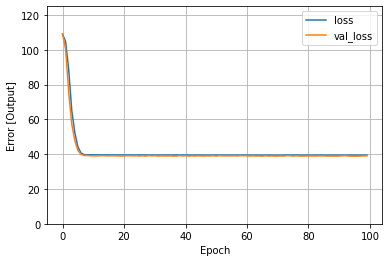

In [163]:
plot_loss(history)

In [144]:
test_results = {}

test_results['target_model'] = target_model.evaluate(
    test_features['target'],
    test_labels, verbose=0)

In [145]:
#Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:
x = tf.linspace(0, 10000, 3001)
y = target_model.predict(x)

94/94 [==============================] - 0s 938us/step


In [146]:
def plot_target(x, y):
    plt.scatter(train_features['target'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('target')
    plt.ylabel('output')
    plt.legend()

In [147]:
train_labels

641     660.00
1344     65.00
229      22.14
458      46.96
565      84.00
         ...  
1853    107.00
1004     59.00
323     165.00
180      51.00
1272     76.00
Name: output, Length: 2049, dtype: float64

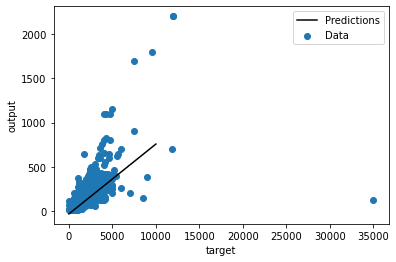

In [148]:
plot_target(x, y)

In [149]:
#The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

#These models will contain a few more layers than the linear model:

#The normalization layer, as before (with target_normalizer for a single-input model and normalizer for a multiple-input model).
#Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
#A linear Dense single-output layer.

In [150]:
def build_and_compile_model(norm): 
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model


In [151]:
#Since all models have been trained, you can review their test set performance:
dnn_target_model = build_and_compile_model(target_normalizer)

In [152]:
dnn_target_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 64)                128       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [153]:
%%time
history = dnn_target_model.fit(
    train_features['target'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 10.2 s


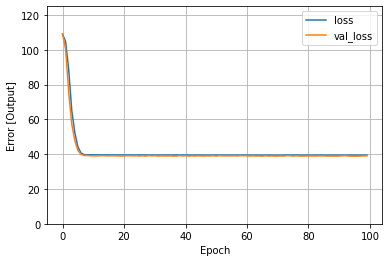

In [164]:
plot_loss(history)

In [155]:
x = tf.linspace(0, 10000, 2001)
y = dnn_target_model.predict(x)

63/63 [==============================] - 0s 1ms/step


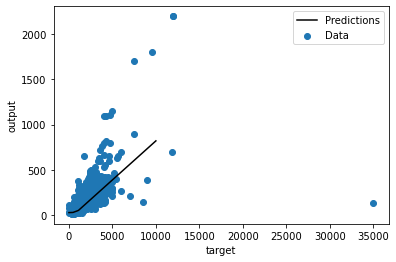

In [156]:
plot_target(x, y)

In [157]:
test_results['dnn_target_model'] = dnn_target_model.evaluate(
    test_features['target'], test_labels,
    verbose=0)

In [160]:
pd.DataFrame(test_results, index=['Mean absolute error [output]']).T

,Mean absolute error [output]
target_model,78.528450
dnn_target_model,78.435196


4/4 [==============================] - 0s 3ms/step


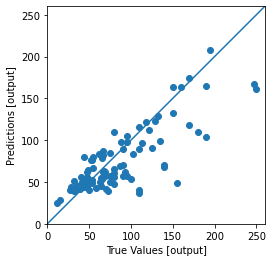

In [161]:
test_predictions = dnn_target_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [output]')
plt.ylabel('Predictions [output]')
lims = [0, 260]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)